# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from functools import partial
from itertools import chain
from operator import itemgetter
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


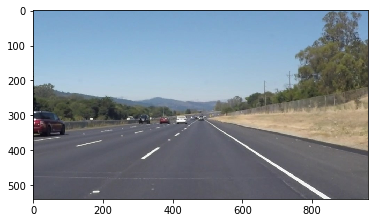

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

# Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Some more helper functions

In [4]:
def get_intersection_with_horizontal_line(line, y):
    """
    Finds x-coordinate of the intersection point of a specified line and a horizontal line.
    The first line is identified by two points, and is considered infinite for the purpose of
    the function. The second horizontal line is identified by its y cooridnate.
    
    :param line: a tuple of coordinates (x1, y1, x2, y2) identifying the first line
    :param y: y-coordinate of the second horizontal line
    :return: x-coordinate of the intersection point or math.inf if the line is horizontal
    """
    x1, y1, x2, y2 = line
    try:
        k_inv = (x2 - x1) / (y2 - y1)
        x = (y - y1) * k_inv + x1
        return x
    except ZeroDivisionError:
        # y1 == y2, i.e. the line is horizontal
        return math.inf

def filter_by_intersection_with_bottom_edge(lines, x_range, frame_height):
    """
    Filters out line segments that intersect bottom edge of the image
    outside of specified region. The function finds x-coordinate of the
    intersection with the bottom edge of the picture frame (y=frame_height)
    for each line and returns only those lines whose x-cooridnate is
    within x_range.
    Each input and output line is identified by coordinates (x1, y1, x2, y2).
    
    :param lines: lines to filter
    :param x_range: (x_min, x_max) of lines to keep
    :param frame_height: image height
    :return: a list of lines
    """
    result = []
    for line in lines:
        x = get_intersection_with_horizontal_line(line, frame_height)
        if x_range[0] < x <= x_range[1]:
            result.append(line)
    return result

def line_segment_to_fn(line, b_at=0):
    """
    Finds a line x=f(y) which line segment belongs to where f(y)=k*y+b.
    Line segment should not be horizontal, otherwise a ValueError is raised.
    By the point when the function is called all horizontal lines are filtered out.
    
    :param line: segment coordinates (x1, y1, x2, y2)
    :returns: a tuple of line parameters k, b
    """
    x1, y1, x2, y2 = line
    try:
        k = (x2 - x1) / (y2 - y1)
        b = -y1 * k + x1
        return k, b
    except ZeroDivisionError:
        # y1 == y2, i.e. line is horizontal
        raise ValueError("Horizontal line segment passed: {}".format(line))

In [5]:
def separate_by_slope(lines):
    """
    Separates lines into two sets of 'left lines' and 'right lines'
    
    A line is considered a 'left line' if its slope is negative,
    and 'right line' if it's slope is zero or positive.
    
    :param line: list of lists of lines, each line is a tuple (x1, y1, x2, y2)
    :return: a tuple of (left_lines, right_lines)
    """
    left_lines = []
    right_lines = []
    
    for line in chain(*lines):
        x1, y1, x2, y2 = line
        is_left_line = (y2 - y1) * (x2 - x1) < 0
        if is_left_line:
            left_lines.append(line)
        else:
            right_lines.append(line)
    
    return left_lines, right_lines

def filter_by_slope(params, lines):
    """
    Filters out lines with too large slope in x=f(y) notation (those that are too close to horizontal).
    
    :param params: algorithm parameters
    :param lines: lines to filter
    :return: a list of lines passing the filter
    """
    slope_threshold = params["filter_by_slope_threshold"]
    return [l for l in lines if abs(line_segment_to_fn(l)[0]) < slope_threshold]

In [6]:
def augment_line(line):
    """
    Augments a line with its parameters k and b, where k is line slope
    and b is x-coordinate of line intersection with the horizontal line y=450.
    
    :param line: line segment coordinates (x1, y1, x2, y2)
    :return: a tuple (k, b, line)
    """
    HORIZONTAL_LINE_POS = 450
    
    k = line_segment_to_fn(line)[0]
    b = get_intersection_with_horizontal_line(line, y=HORIZONTAL_LINE_POS)
    return (k, b, line)

def merge_line_segments(lines):
    """
    Merges line segments with a similar slope and intersection with a horizontal line.
    
    The function finds slope and x-coordinate of intersection with a horizontal
    line for each line, then groups lines that have close values of k and
    intersection point. Lines in the same group are merged into a single line
    segment by taking the most distant points from merged lines.
    
    Example:
                P2
            C /
             /
            /
           
        B /
         /
        /
       
    A /
     /
    /
     P1
     
    In the example above line segments A, B and C have the same slope, and the same
    itersection point with a horizontal line. They are going to be merged into a
    single line segment with end points (P1, P2).
    
    :param lines: a list of lines to merge
    :return: a list of merged lines
    """
    
    # Augment lines with k and b
    augmented_lines = [augment_line(l) for l in lines]

    # Sort by k (slope)
    augmented_lines.sort(key=itemgetter(0))
    
    def get_merged_line(i, j):
        """
        Merges two lines from augmented_lines list.
        The function returns the merged line and does not modify augmented_lines.
        The lines are merged by taking the most distant points from the four line ends.
        
        :param i: index of the first line
        :param j: index of the second line
        :return: merged line
        """
        
        x1i, y1i, x2i, y2i = augmented_lines[i][2]
        x1j, y1j, x2j, y2j = augmented_lines[j][2]
        all_x = (x1i, x2i, x1j, x2j)
        all_y = (y1i, y2i, y1j, y2j)
        minx, maxx = min(all_x), max(all_x)
        miny, maxy = min(all_y), max(all_y)
        k1 = augmented_lines[i][0]
        if k1 < 0:
            merged_line = (minx, maxy, maxx, miny)
        else:
            merged_line = (minx, miny, maxx, maxy)
        return merged_line
    
    def merge_up(i):
        """
        Starting from index i looks up in the augmented_lines array
        and merges lines with a similar value of k.
        Two lines are merged by taking the most distant pairs of (x, y).
        
        The function looks 'up' (towards the beginning) in the list starting from index i.
        
        :param i: index of the candidate line to be merged
        :return: index of the merged line or None if no lines were merged.
        """
        
        # Threshold of distance of the ratio k1/k2 from 1 that the lines
        # must have to be merged
        K_TRS = 0.2
        
        # Maximum allowed distance of intersection points of two lines
        # with a horizontal line
        B_TRS = 50
        
        for j in range(i - 1, -1, -1):
            # Find k, b of two candidate lines for merging
            k1, b1 = augmented_lines[i][:2]
            k2, b2 = augmented_lines[j][:2]
            
            # Lines should be either both 'left' or both 'right', i.e.
            # their slopes should have the same sign
            if k1 * k2 <= 0:
                continue
            
            # Both k and b should be in the same range
            if abs(k1 / k2 - 1) > K_TRS or abs(b1 - b2) > B_TRS:
                continue

            augmented_lines[j] = augment_line(get_merged_line(i, j))
            augmented_lines.pop(i)
            # Try to merge up recursively
            recursive_result = merge_up(j)
            return i if recursive_result is None else recursive_result
        return None
            
    i = 1
    while i < len(augmented_lines):
        merged_idx = merge_up(i)
        if merged_idx is not None:
            # Take max() to skip line 0 since there's no other line to merge line 0 with
            i = max(merged_idx, 1)
        else:
            i += 1

    # Return only line coordinates without k and b parameters
    return [al[2] for al in augmented_lines]

In [7]:
def get_line_length(line):
    """
    Computes length of a line segment.
    
    :param line: line segment coordinates (x1, y1, x2, y2)
    :return: line segment length
    """
    x1, y1, x2, y2 = line 
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def get_longest(lines):
    """
    Finds the longest line in the list of line segments represented
    as 4-point tuples (x1, y1, x2, y2).
    
    :param lines: a list of line segments
    :return: coordinates (x1, y1, x2, y2) of the longest line segment.
    """
    if not lines:
        return lines
    
    max_line = lines[0]
    max_len = get_line_length(max_line)
    
    for line in lines[1:]:
        line_len = get_line_length(line)
        if line_len > max_len:
            max_len = line_len
            max_line = line
    
    return [max_line]

In [8]:
def average_line_fn_params(lines):
    """
    Averages line segment parameters k and b, for a line x=k*y+b

    :param lines: a collection of lines, each line is a tuple (x1, y1, x2, y2)
    :return: a tuple of average values (k, b)
    """
    k_collection = []
    b_collection = []
    for line in lines:
        segment_k, segment_b = line_segment_to_fn(line)
        k_collection.append(segment_k)
        b_collection.append(segment_b)
    return np.average(k_collection), np.average(b_collection)

def extrapolate_to(params, lines, y1, y2):
    """
    Extrapolates a collection of line segments to a single segment
    with start at y=y1 and stop at y=y2.
    
    :param lines: a collection of lines, each line is a tuple (x1, y1, x2, y2)
    :param y1: y-coordinate of start extrapolated line segment
    :param y2: y-coordinate of end of extrapolated line segment
    :return: extrapolated line coordinates (x1, y1, x2, y2)
    """
    
    # Optionally merge line segments that lay on the same line
    # before extrapolating
    if params["merge_segments"]:
        lines = get_longest(merge_line_segments(lines))
        
    k, b = average_line_fn_params(lines)
    x1 = y1 * k + b
    x2 = y2 * k + b
    
    return (int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2)))

def filter_by_min_x(lines, min_x):
    """
    Returns lines that have min(x1, x2) > min_x
    
    :param lines: list of lines
    :return: list of lines that pass the filter
    """
    return [l for l in lines if min(l[0], l[2]) > min_x]

def filter_by_max_x(lines, max_x):
    """
    Returns lines that have max(x1, x2) < max_x
    
    :param lines: list of lines
    :return: list of lines that pass the filter
    """
    return [l for l in lines if max(l[0], l[2]) < max_x]
    
def get_lane_lines(params, lines, imshape):
    """
    Retrieves possible lane lines from a list of line segments,
    separating the to left and right lines.
    
    :param params: algorithm parameters
    :param lines: a list of lines
    :return: a tuple of (left_lines, right_lines)
    """
    height, width = imshape
    left_lines, right_lines = separate_by_slope(lines)

    # Optionally exclude lines with too gentle slope
    if params.get("filter_by_slope"):
        left_lines = filter_by_slope(params, left_lines)
        right_lines = filter_by_slope(params, right_lines)
    
    # Optionally exclude lines that go beyond region of interest
    if params.get("filter_by_intersection"):
        left_lines = filter_by_intersection_with_bottom_edge(left_lines, [width * 0.05, width / 2], height)
        right_lines = filter_by_intersection_with_bottom_edge(right_lines, [width / 2, width * 0.95], height)
    
    # Optionally filter by line endpoints
    if params.get("filter_by_endpoints"):
        # Remove left lines that go too far to the right
        left_lines = filter_by_max_x(left_lines, width * 0.6)
        # Remove right lines that go too far to the left
        right_lines = filter_by_min_x(right_lines, width * 0.4)
    
    return left_lines, right_lines

In [9]:
def draw_extrapolated(params, img, lines, color, thickness):
    """
    Draws line segments. Each line segment is extrapolated
    to go from 60% of image height to the bottom of the image.
    
    :param params: algorithm parameters
    :param img: image to draw lines on
    :param lines: lines to extrapolate and draw
    :color: line color
    :thickness: line thickness
    """
    if lines:
        height = img.shape[0]
        extrapolated = extrapolate_to(params, lines, height * 0.6, height)
        lx1, ly1, lx2, ly2 = extrapolated
        cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)

def draw_segments(img, lines, color, thickness):
    """
    Draws line segments.
    
    :param img: image to draw lines on
    :param lines: lines to draw
    :param color: line color
    :param thickness: line thickness
    """
    for x1,y1,x2,y2 in lines:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
def draw_lines(params, img, lines):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines is None:
        return
    
    # Get possible lane line segments
    left_lines, right_lines = get_lane_lines(params, lines, img.shape[:2])

    # Draw extrapolated lines (if configured)
    try:
        p = params["draw"]["lanes"]
        thickness = p["thickness"]
        if thickness and params["extrapolate"]:
            draw_extrapolated(params, img, left_lines, p["left_color"], thickness)
            draw_extrapolated(params, img, right_lines, p["right_color"], thickness)
    except KeyError:
        # No settings to draw extrapolated lines in params
        pass

    # Draw line segments (if configured)
    try:
        sp = params["draw"]["segments"]
        sp_thickness = sp["thickness"]
    
        if thickness and params["draw_segments"]:
            draw_segments(img, left_lines, sp["left_color"], sp_thickness)
            draw_segments(img, right_lines, sp["right_color"], sp_thickness)
    except KeyError:
        # No segment draw settings in params
        pass

In [10]:
def hough_lines(params, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(params, line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [11]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [12]:
IGNORE_MASK_COLOR = 255

def create_mask(params, imshape):
    """
    Creates a 'region of interest' mask.
    
    :param params: algorithm parameters
    :param imshape: shape of the region of interest
    :return: mask image
    """
    height = imshape[0]
    width = imshape[1]
    
    region_params = params["region_of_interest"]
    bottom_sides_margin = region_params["bottom_sides_margin"]
    top_sides_margin = region_params["top_sides_margin"]
    top_margin = region_params["top_margin"]
    
    mask = np.zeros(shape=imshape, dtype='uint8')
    vertices = np.array([[
        (width * bottom_sides_margin, height),        # bottom-left
        (width * top_sides_margin, height * top_margin),  # center-left
        (width * (1 - top_sides_margin), height * top_margin),  # center-right
        (width * (1 - bottom_sides_margin), height)         # bottom-right
    ]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, IGNORE_MASK_COLOR)
    return mask

def apply_mask(image, mask):
    """
    Applies a 'region of interest' mask to an image.
    
    :param image: image to apply a mask to
    :param mask: mask to apply
    :return: image with mask applied
    """
    return cv2.bitwise_and(image, mask)

In [13]:
# Pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def mark_lines(params, mask, image):
    """
    Detects and annotates lane lines on an image.
    Lines are annotated by marking them with a color.
    
    :param params: algorithm parameters
    :param mask: region of interest
    :param image: image to find and annotate lines
    :return: image with lines annotated
    """
    grayscale_image = grayscale(image)
    blurred_grayscale_image = gaussian_blur(img=grayscale_image, kernel_size=5)
    edges = canny(img=blurred_grayscale_image, low_threshold=50, high_threshold=150)
    edges = apply_mask(edges, mask)

    lines = hough_lines(params, img=edges, rho=2, theta=(np.pi/180), threshold=15, min_line_len=40, max_line_gap=20)

    return weighted_img(lines, image)

In [14]:
# Simple pipeline parameters, disables segments extrapolation and merging.
SIMPLE_PARAMS = {
    "extrapolate": False,
    "merge_segments": False,
    "draw_segments": True,
    
    "filter_by_intersection": True,
    
    "region_of_interest": {
        "bottom_sides_margin": 0.05,
        "top_sides_margin": 0.45,
        "top_margin": 0.6,
        "bottom_margin": 1
    },
    "draw": {
        "lanes": {
            "left_color": [255, 0, 0],
            "right_color": [0, 255, 0],
            "thickness": 16
        },
        "segments": {
            "left_color": [0, 0, 255],
            "right_color": [0, 0, 255],
            "thickness": 5
        }
    }
}

solidWhiteCurve.jpg


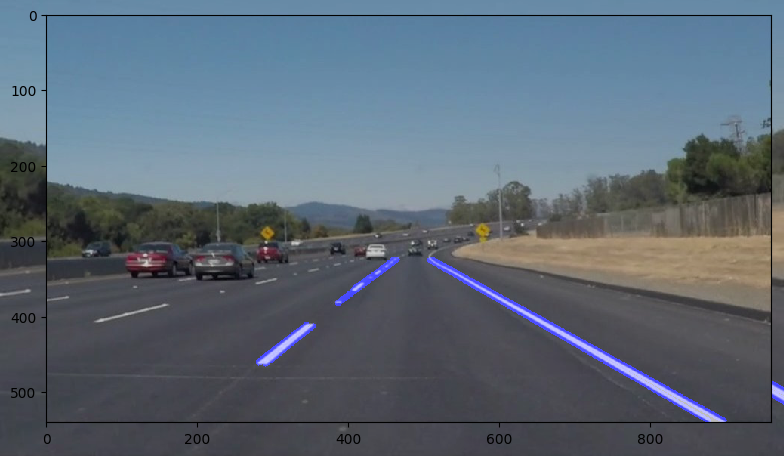

solidWhiteRight.jpg


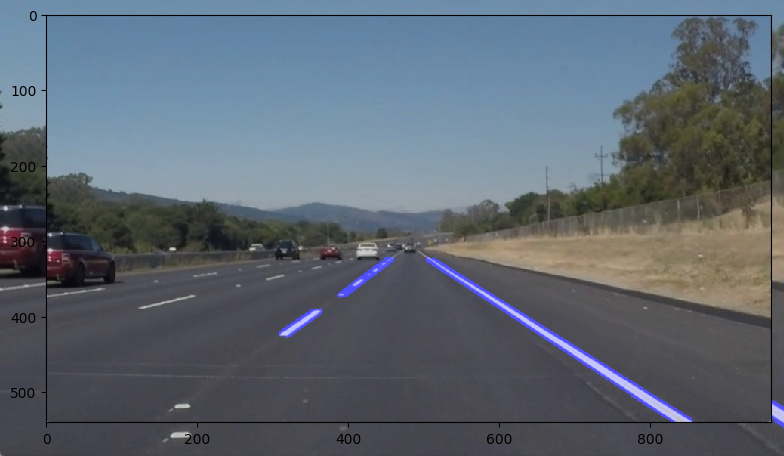

solidYellowCurve.jpg


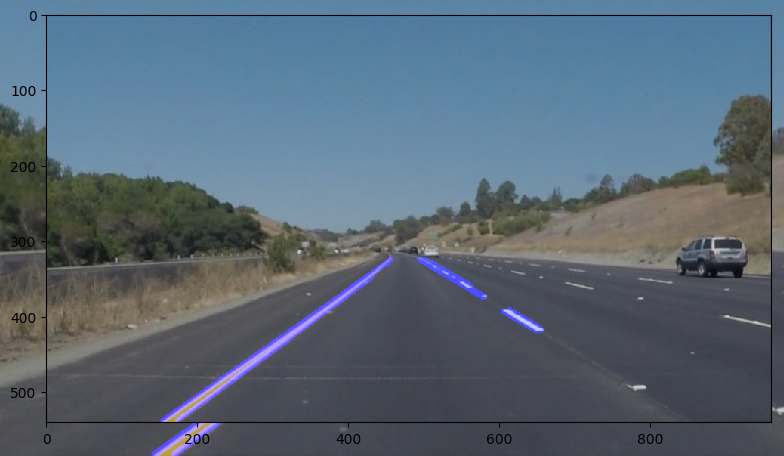

solidYellowCurve2.jpg


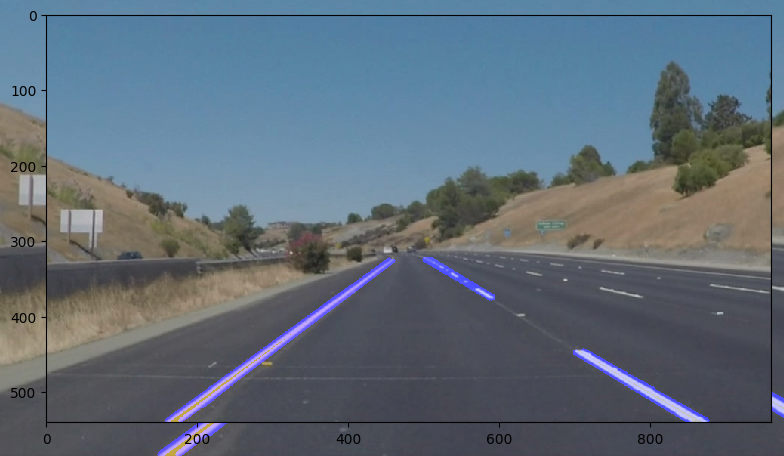

solidYellowLeft.jpg


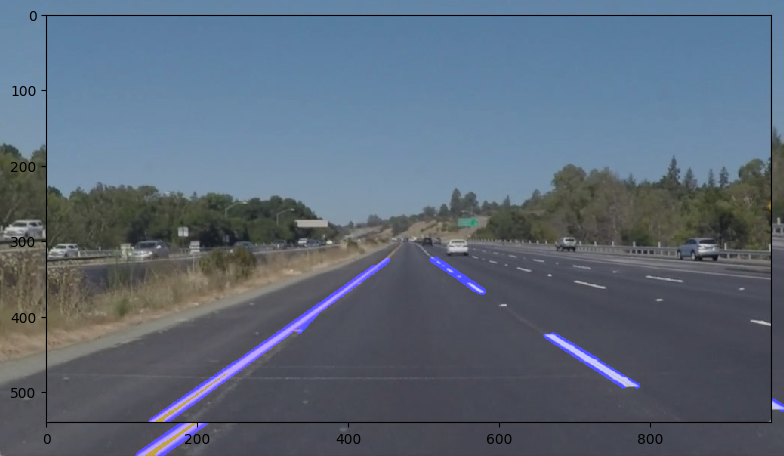

whiteCarLaneSwitch.jpg


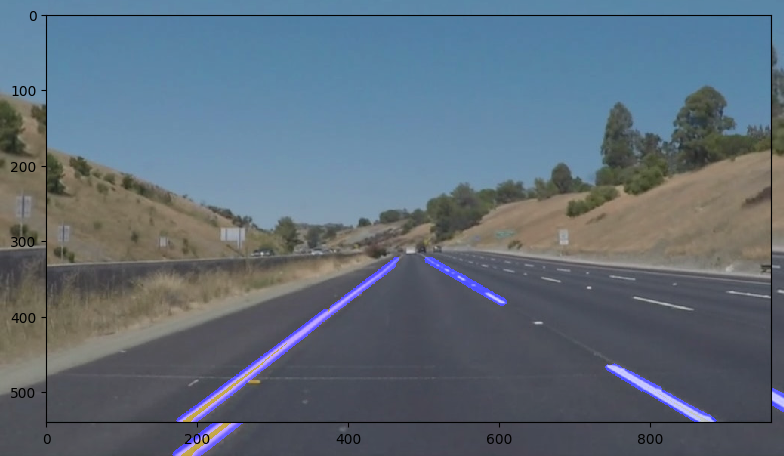

In [15]:
def test_pipeline():
    """
    Tests the simple lane detection pipeline.
    """
    TEST_IMAGES_FOLDER = "test_images/"
    OUTPUT_IMAGES_FOLDER = "test_images_output/"
    DPI = 100.0  # "Virtual" DPI
    
    for image_file_name in os.listdir(TEST_IMAGES_FOLDER):
        source_image = mpimg.imread(os.path.join(TEST_IMAGES_FOLDER, image_file_name))
        imshape = source_image.shape
        print(image_file_name)

        mask = create_mask(SIMPLE_PARAMS, imshape[:2])
        marked_image = mark_lines(SIMPLE_PARAMS, mask, source_image)
        
        fig = plt.figure(figsize=(imshape[1] / DPI, imshape[0] / DPI), dpi=DPI)
        fig.figimage(marked_image)
        plt.imshow(marked_image, cmap='gray')
        mpimg.imsave(os.path.join(OUTPUT_IMAGES_FOLDER, image_file_name), marked_image)
        plt.show()

test_pipeline()

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(params, mask, image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return mark_lines(params, mask, image)

Let's try the one with the solid white lane on the right first ...

In [18]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

mask = create_mask(SIMPLE_PARAMS, (clip1.size[1], clip1.size[0]))
processor = lambda img: process_image(SIMPLE_PARAMS, mask, img)

white_clip = clip1.fl_image(processor) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:09<00:00, 22.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.51 s, sys: 847 ms, total: 7.36 s
Wall time: 10.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [20]:
# Improved pipeline parameters, enables extrapolation
IMPROVED_PARAMS = {
    "extrapolate": True,
    "merge_segments": False,
    "draw_segments": False,
    
    "filter_by_intersection": True,
    "filter_by_endpoints": True,
    
    "region_of_interest": {
        "bottom_sides_margin": 0.05,
        "top_sides_margin": 0.45,
        "top_margin": 0.6,
        "bottom_margin": 1
    },
    "draw": {
        "lanes": {
            "left_color": [255, 0, 0],
            "right_color": [255, 0, 0],
            "thickness": 16
        },
        "segments": {
            "left_color": [0, 0, 255],
            "right_color": [0, 0, 255],
            "thickness": 5
        }
    }
}

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')

mask = create_mask(IMPROVED_PARAMS, (clip2.size[1], clip2.size[0]))
processor = lambda img: process_image(IMPROVED_PARAMS, mask, img)

yellow_clip = clip2.fl_image(processor)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:32<00:00, 17.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 21.2 s, sys: 2.62 s, total: 23.9 s
Wall time: 34.1 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [23]:
# Lane marking pipeline to tackle the challenge, enables line merging and extrapolation
CHALLENGE_PARAMS = {
    "extrapolate": True,
    "merge_segments": True,
    "draw_segments": True,

    "filter_by_intersection": True,
    "filter_by_endpoints": True,
    "filter_by_slope": True,
    "filter_by_slope_threshold": 2,  # 45 degrees
    
    "region_of_interest": {
        "bottom_sides_margin": 0.05,
        "top_sides_margin": 0.45,
        "top_margin": 0.6,
        "bottom_margin": 1
    },
    "draw": {
        "lanes": {
            "left_color": [255, 0, 0],
            "right_color": [255, 0, 0],
            "thickness": 16
        },
        "segments": {
            "left_color": [0, 0, 255],
            "right_color": [0, 0, 255],
            "thickness": 5
        }
    }
}

In [24]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')

mask = create_mask(CHALLENGE_PARAMS, (clip3.size[1], clip3.size[0]))
processor = lambda img: process_image(CHALLENGE_PARAMS, mask, img)

challenge_clip = clip3.fl_image(processor)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:23<00:00, 10.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 14.2 s, sys: 1.96 s, total: 16.2 s
Wall time: 24.9 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))